Auteur : Francis de Ladurantaye<br>
Matricule : 990316<br>
Date : 2018/11/01

In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

train_data = np.loadtxt('EMGaussian.train')
test_data = np.loadtxt('EMGaussian.test')

### a) Implementation of the K-means algorithm

In [2]:
def K_means(data, K):
    
    # size and dimension data
    n = np.size(data, axis=0)
    d = np.size(data, axis=1)
    
    # we randomly initialize our K means using K random data points
    indexes = np.arange(n)
    np.random.shuffle(indexes)
    μ_tp1 = np.copy(data[indexes[:K]])
    μ_t = np.zeros((K,d))
    
    
    while(np.any(μ_tp1 != μ_t)):
        
        μ_t = np.copy(μ_tp1)
        
        # E step
        z = np.zeros((n,K))
        dist = np.ndarray((n,K))
        
        for k in range(K):
            diff = data - μ_t[k]
            dist[:,k] = np.sum(diff ** 2, axis=1)
            
        z[np.arange(n), np.argmin(dist, axis=1)] = 1
        
        # M step
        class_counts = np.sum(z, axis=0)
        for k in range(K):
            μ_tp1[k] = np.dot(z[:,k], data) / class_counts[k]
    
    
    # cost calculation
    J = 0
    for k in range(K):
        J += np.dot(z[:,k], dist[:,k])
    
    print('J = ' + str(J))
    print('μ =\n' + str(μ_t) + '\n')
    
    return J, z, μ_t

In [3]:
def multiple_K_means(data, nb_iterations):
    
    J_best = np.inf

    for i in range(nb_iterations):
        J, z, μ = K_means(data, K=4)
        if J < J_best:
            J_best = J
            z_best = np.copy(z)
            μ_best = np.copy(μ)

    π_best = np.sum(z_best, axis=0) / np.sum(z_best)

    plt.scatter(data[:,0], data[:,1], c=np.argmax(z_best, axis=1))
    plt.scatter(μ_best[:,0], μ_best[:,1], c='red', marker='X')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('K-means with K=4 clusters')
    plt.show()

    print('J_best = ' + str(J_best))
    print('μ_best =\n' + str(μ_best))
    
    return π_best, μ_best

J = 3240.173266362519
μ =
[[-2.14180002  3.97338429]
 [ 3.57429183 -2.880828  ]
 [ 3.78809286  4.99905357]
 [-3.72020481 -4.1849974 ]]

J = 3240.1732663625185
μ =
[[ 3.78809286  4.99905357]
 [-3.72020481 -4.1849974 ]
 [-2.14180002  3.97338429]
 [ 3.57429183 -2.880828  ]]

J = 3241.28275723632
μ =
[[ 3.78809286  4.99905357]
 [-3.79520578 -4.24816219]
 [-2.14180002  3.97338429]
 [ 3.48330393 -2.84991997]]

J = 3237.7795964961347
μ =
[[ 3.80280826  5.10467248]
 [ 3.33557966 -2.644529  ]
 [-2.24034752  4.12744772]
 [-3.81879354 -4.27423441]]

J = 3240.1732663625185
μ =
[[-3.72020481 -4.1849974 ]
 [ 3.57429183 -2.880828  ]
 [-2.14180002  3.97338429]
 [ 3.78809286  4.99905357]]

J = 6410.629066379608
μ =
[[-3.62252549  3.88061894]
 [-0.4352141  -3.7744641 ]
 [ 3.8419      4.18459392]
 [-1.11657347  4.31598129]]

J = 3241.222949028221
μ =
[[-2.14180002  3.97338429]
 [ 3.80007477  5.03387387]
 [ 3.47576567 -2.82062644]
 [-3.79520578 -4.24816219]]

J = 3240.381740244571
μ =
[[ 3.60401871 -2.887

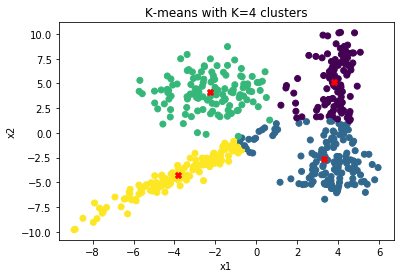

J_best = 3237.7795964961347
μ_best =
[[ 3.80280826  5.10467248]
 [ 3.33557966 -2.644529  ]
 [-2.24034752  4.12744772]
 [-3.81879354 -4.27423441]]


In [4]:
np.random.seed(6269)
π, μ = multiple_K_means(train_data, 10)

### b) GMM with proportional to identity covariance matrices

In [5]:
def EM_σ2I(data, π_0, μ_0):
    
    # size and dimension of data
    n = np.size(data, axis=0)
    d = np.size(data, axis=1)
    K = np.size(μ, axis=0)
    
    # initialization
    τ_t = np.ndarray((n,K))
    μ_t = np.zeros(μ_0.shape)
    
    π_tp1 = np.copy(π_0)
    μ_tp1 = np.copy(μ_0)
    σ2_tp1 = 10 * np.ones(K)
    
    p_x_z = np.ndarray((n,K))
    
    while(np.any(np.abs(μ_tp1 - μ_t) > 1e-16)):
        
        π_t = np.copy(π_tp1)
        μ_t = np.copy(μ_tp1)
        σ2_t = np.copy(σ2_tp1)
        
        # E step
        for k in range(K):
            diff = data - μ_t[k]
            for i in range(n):
                diff_x_i = diff[i].reshape((d,1))
                N_x_i = np.exp(-1/2 * np.dot(diff_x_i.T, diff_x_i) / σ2_t[k])
                N_x_i /= 2 * np.pi * σ2_t[k]
                p_x_z[i,k] = π_t[k] * N_x_i
        
        p_x = np.sum(p_x_z, axis=1)
        
        τ_t = np.transpose(p_x_z.T / p_x.T)
        soft_counts = np.sum(τ_t, axis=0)
        
        # M step
        π_tp1 = soft_counts / n
        
        o2_tp1 = np.zeros(K)
        
        for k in range(K):
            
            μ_tp1[k,:] = np.sum(np.transpose(τ_t[:,k].T * data.T), axis=0) / soft_counts[k]
            
            diff = data - μ_tp1[k]
            for i in range(n):
                diff_x_i = diff[i].reshape((d,1))
                σ2_tp1[k] += τ_t[i,k] * np.dot(diff_x_i.T, diff_x_i)
            σ2_tp1[k] /= 2 * soft_counts[k]
            
    
    x_min = np.min(data[:,0])
    x_max = np.max(data[:,0])
    x = np.linspace(x_min, x_max, n)
    
    colors = ['r','g','y','m']
    
    fig, ax = plt.subplots()
    
    ax.scatter(data[:,0], data[:,1], marker='.')
    
    for k in range(K):
        ax.scatter(μ_t[k,0], μ_t[k,1], c=colors[k], marker='X')
        for s in [9.210, 5.991, 4.605]:
            ax.add_patch(mpatches.Circle((μ_t[k,0], μ_t[k,1]),
                                         (σ2_t[k] * s)**(1/2),
                                         edgecolor=colors[k],
                                         facecolor='None'))
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('GMM with proportional to identity covariance matrix')
    plt.show()

    print('π_hat = ' + str(π_t))
    print('μ_hat =\n' + str(μ_t))
    print('σ²_hat = ' + str(σ2_t))
    
    return π_t, μ_t, σ2_t

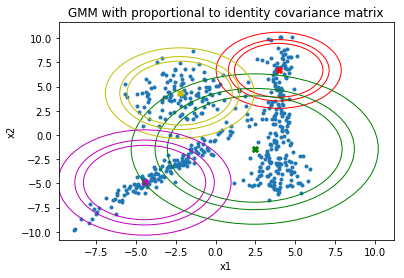

π_hat = [0.13384815 0.45232615 0.22196243 0.19186326]
μ_hat =
[[ 3.96406416  6.6852745 ]
 [ 2.45566608 -1.45393225]
 [-2.25924141  4.33055879]
 [-4.47128731 -4.91107704]]
σ²_hat = [1.67945029 6.55439708 2.37211439 3.21158002]


In [6]:
π_train_prop, μ_train_prop, σ2_train_prop = EM_σ2I(train_data, π, μ)

### c) GMM with general covariance matrices

In [7]:
def EM_Σ(data, π_0, μ_0):
    
    # size and dimension of data
    n = np.size(data, axis=0)
    d = np.size(data, axis=1)
    K = np.size(μ, axis=0)
    
    # initialization
    τ_t = np.ndarray((n,K))
    μ_t = np.zeros(μ_0.shape)
    
    π_tp1 = np.copy(π_0)
    μ_tp1 = np.copy(μ_0)
    Σ_tp1 = np.ndarray((K,d,d))
    for k in range(K):
        Σ_tp1[k] = 10 * np.identity(d)
    
    p_x_z = np.ndarray((n,K))
    
    while(np.any(μ_tp1 != μ_t)):
        
        π_t = np.copy(π_tp1)
        μ_t = np.copy(μ_tp1)
        Σ_t = np.copy(Σ_tp1)
        
        # E step
        Σ_inverse = np.linalg.pinv(Σ_t)
        
        for k in range(K):
            diff = data - μ_t[k]
            for i in range(n):
                diff_x_i = diff[i].reshape((d,1))
                N_x_i = np.exp(-1/2 * np.matmul(diff_x_i.T, Σ_inverse[k].dot(diff_x_i)))
                N_x_i /= (2 * np.pi * np.linalg.det(Σ_t[k])) ** (1/2)
                p_x_z[i,k] = π_t[k] * N_x_i
        
        p_x = np.sum(p_x_z, axis=1)
        
        τ_t = np.transpose(p_x_z.T / p_x.T)
        soft_counts = np.sum(τ_t, axis=0)
        
        # M step
        π_tp1 = soft_counts / n
        
        Σ_tp1 = np.zeros((K,d,d))
        
        for k in range(K):
            
            μ_tp1[k,:] = np.sum(np.transpose(τ_t[:,k].T * data.T), axis=0) / soft_counts[k]
            
            diff = data - μ_tp1[k]
            for i in range(n):
                diff_x_i = diff[i].reshape((d,1))
                diff2_x_i = np.dot(diff_x_i, diff_x_i.T)
                Σ_tp1[k] += τ_t[i,k] * diff2_x_i
            Σ_tp1[k] /= soft_counts[k]
            
    
    x_min = np.min(data[:,0])
    x_max = np.max(data[:,0])
    x = np.linspace(x_min, x_max, n)
    
    colors = ['r','g','y','m']
    
    fig, ax = plt.subplots()
    
    ax.scatter(data[:,0], data[:,1], marker='.')
    
    for k in range(K):
        ax.scatter(μ_t[k,0], μ_t[k,1], c=colors[k], marker='X')
        λ, v = np.linalg.eig(Σ_t[k])
        for s in [9.210, 5.991, 4.605]:
            ax.add_patch(mpatches.Ellipse((μ_t[k,0], μ_t[k,1]),
                                          2 * (λ[0] * s)**(1/2),
                                          2 * (λ[1] * s)**(1/2),
                                          np.arccos(v[0,0]) * 360 / (2 * np.pi),
                                          edgecolor=colors[k],
                                          facecolor='None'))
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('GMM with general covariance matrix')
    plt.show()

    print('π_hat = ' + str(π_t))
    print('μ_hat =\n' + str(μ_t))
    print('Σ_hat =\n' + str(Σ_t))
    
    return π_t, μ_t, Σ_t

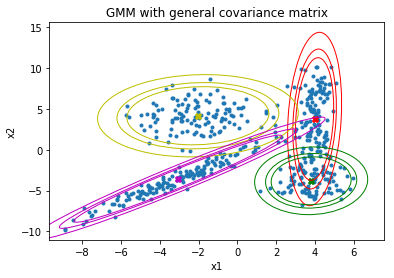

π_hat = [0.25998574 0.18290156 0.25155719 0.30555552]
μ_hat =
[[ 3.97793025  3.77333059]
 [ 3.80070949 -3.79729742]
 [-2.03436695  4.17258596]
 [-3.06196072 -3.53454048]]
Σ_hat =
[[[ 0.21035667  0.29045085]
  [ 0.29045085 12.23996609]]

 [[ 0.92127927  0.0573808 ]
  [ 0.0573808   1.86586017]]

 [[ 2.90442381  0.20655763]
  [ 0.20655763  2.75617077]]

 [[ 6.24140909  6.05017464]
  [ 6.05017464  6.18245528]]]


In [8]:
π_train_gen, μ_train_gen, Σ_train_gen = EM_Σ(train_data, π, μ)

### d) Results on test data and log-likelihoods

J = 4705.39126448274
μ =
[[-2.43123773  3.72101767]
 [ 3.91432182  2.24219531]
 [ 3.69661101  7.13948261]
 [ 1.03790776 -3.83813113]]

J = 3025.3547234668945
μ =
[[ 3.84277159  4.94263697]
 [-2.33018341  3.59914796]
 [ 3.78959372 -3.23355612]
 [-3.77390431 -4.20837354]]

J = 3025.4570827773036
μ =
[[ 3.81831783 -3.25254988]
 [ 3.84277159  4.94263697]
 [-3.77390431 -4.20837354]
 [-2.31590515  3.57149725]]

J = 3025.354723466894
μ =
[[-2.33018341  3.59914796]
 [ 3.78959372 -3.23355612]
 [ 3.84277159  4.94263697]
 [-3.77390431 -4.20837354]]

J = 3025.3547234668945
μ =
[[ 3.78959372 -3.23355612]
 [-3.77390431 -4.20837354]
 [ 3.84277159  4.94263697]
 [-2.33018341  3.59914796]]

J = 3025.354723466894
μ =
[[-3.77390431 -4.20837354]
 [-2.33018341  3.59914796]
 [ 3.84277159  4.94263697]
 [ 3.78959372 -3.23355612]]

J = 3025.3547234668945
μ =
[[ 3.84277159  4.94263697]
 [-2.33018341  3.59914796]
 [ 3.78959372 -3.23355612]
 [-3.77390431 -4.20837354]]

J = 3025.3547234668945
μ =
[[-3.77390431 -4.2

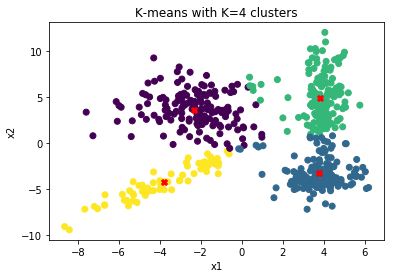

J_best = 3025.354723466894
μ_best =
[[-2.33018341  3.59914796]
 [ 3.78959372 -3.23355612]
 [ 3.84277159  4.94263697]
 [-3.77390431 -4.20837354]]


In [ ]:
np.random.seed(6269)
π, μ = multiple_K_means(test_data, 10)

π_test_prop, μ_test_prop, σ2_test_prop = EM_σ2I(test_data, π, μ)
π_test_gen, μ_test_gen, Σ_test_gen = EM_Σ(test_data, π, μ)

In [ ]:
def log_likelihood_prop(data, π, μ, σ2, K=4):
    
    n = np.size(data, axis=0)

    LL_value = 0
    for i in range(n):
        acc = 0
        for k in range(K):
            diff = data[i] - μ[k]
            N_x_i = np.exp(-1/2 * diff.dot(diff) / σ2[k])
            N_x_i /= 2 * np.pi * σ2[k]
            acc += π[k] * N_x_i
        LL_value += np.log(acc)
    LL_value /= n
    
    return LL_value

In [ ]:
def log_likelihood_gen(data, π, μ, Σ, K=4):
    
    n = np.size(data, axis=0)

    LL_value = 0
    for i in range(n):
        acc = 0
        for k in range(K):
            diff = data[i] - μ[k]
            N_x_i = np.exp(-1/2 * diff.dot(np.linalg.pinv(Σ[k])).dot(diff))
            N_x_i /= (2 * np.pi * np.linalg.det(Σ[k])) ** (1/2)
            acc += π[k] * N_x_i
        LL_value += np.log(acc)
    LL_value /= n
    
    return LL_value

In [ ]:
LL_train_prop = log_likelihood_prop(train_data, π_train_prop, μ_train_prop, σ2_train_prop)
LL_train_gen = log_likelihood_gen(train_data, π_train_gen, μ_train_gen, Σ_train_gen)

LL_test_prop = log_likelihood_prop(test_data, π_test_prop, μ_test_prop, σ2_test_prop)
LL_test_gen = log_likelihood_gen(test_data, π_test_gen, μ_test_gen, Σ_test_gen)

print('Log-likelihood with proportional to identity covariance matrices:')
print('train_data: ' + str(LL_train_prop))
print('test_data: ' + str(LL_test_prop))
print()
print('Log-likelihood with general covariance matrices:')
print('train_data: ' + str(LL_train_gen))
print('test_data: ' + str(LL_test_gen))